In [6]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore")

from gensim import models
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

from sklearn.model_selection import train_test_split


## Получаем датасет

In [7]:
df = pd.read_csv(r'.\simpsons_script_lines.csv',low_memory=False,on_bad_lines='skip')

In [8]:
df = df[['raw_character_text','normalized_text']].astype(str)
df = df[~(df['raw_character_text'] == 'nan') & ~(df['normalized_text'] == 'nan') ].reset_index(drop=True)

In [9]:
#df['normalized_text'] = [(fr'{i+1}\t{x}\n').split(" ") for i,x in enumerate(df['normalized_text'].values) ]
df['normalized_text']  = df['normalized_text'] .apply(lambda x: x.split(" "))

In [10]:
df['normalized_text'] = df['normalized_text'].apply(lambda x: [y for y in x if y not in stopwords.words('english') ])

In [11]:
df = df[df['normalized_text'].apply(len)>0].reset_index(drop=True)

In [12]:
df

raw_character_text  \
0                   Miss Hoover   
1                  Lisa Simpson   
2                   Miss Hoover   
3                  Lisa Simpson   
4       Edna Krabappel-Flanders   
...                         ...   
129921              Miss Hoover   
129922              Miss Hoover   
129923              Miss Hoover   
129924             Ralph Wiggum   
129925                    JANEY   

                                          normalized_text  
0       [actually, little, sometimes, disease, magazin...  
1                                 [wheres, mr, bergstrom]  
2       [dont, know, although, id, sure, like, talk, d...  
3                                   [life, worth, living]  
4       [polls, open, end, recess, case, decided, put,...  
...                                                   ...  
129921                                         [im, back]  
129922                [see, class, lyme, disease, turned]  
129923                                [psy-cho-so-ma-tic]  
129924                                      [mean, crazy]  
129925                                    [means, faking]  

[129926 rows x 2 columns]

## Обучаем Word2Vec

In [13]:
sentences = list(df['normalized_text'])
model = models.Word2Vec()
model.build_vocab(sentences)
model.train(sentences, total_examples=model.corpus_count, epochs=50)

(31163597, 36931950)

In [14]:
words = [x for x in model.wv.index_to_key[:] if x !='nan']

In [15]:
vecs = np.array([ model.wv[x] for x in words ])

## Визуализируем топ 100 слова

In [16]:
from sklearn.manifold import TSNE

In [17]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(vecs)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 11584 samples in 0.001s...
[t-SNE] Computed neighbors for 11584 samples in 0.870s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11584
[t-SNE] Computed conditional probabilities for sample 2000 / 11584
[t-SNE] Computed conditional probabilities for sample 3000 / 11584
[t-SNE] Computed conditional probabilities for sample 4000 / 11584
[t-SNE] Computed conditional probabilities for sample 5000 / 11584
[t-SNE] Computed conditional probabilities for sample 6000 / 11584
[t-SNE] Computed conditional probabilities for sample 7000 / 11584
[t-SNE] Computed conditional probabilities for sample 8000 / 11584
[t-SNE] Computed conditional probabilities for sample 9000 / 11584
[t-SNE] Computed conditional probabilities for sample 10000 / 11584
[t-SNE] Computed conditional probabilities for sample 11000 / 11584
[t-SNE] Computed conditional probabilities for sample 11584 / 11584
[t-SNE] Mean sigma: 1.050386
[t-SNE] KL divergenc

In [18]:
df2 = pd.DataFrame(np.concatenate((tsne_results,np.array(words).reshape((-1,1))),axis=1),columns=['x','y','word'])
df2[['x','y']] = df2[['x','y']].astype(np.float32)
df2.head()

x         y  word
0 -4.591478 -3.101467    im
1 -1.236796 -4.612621    oh
2  5.089579 -0.240638  well
3  0.507951 -5.731354  dont
4  0.462890 -4.939290  like

In [19]:
df2 = df2.iloc[:1000,:]

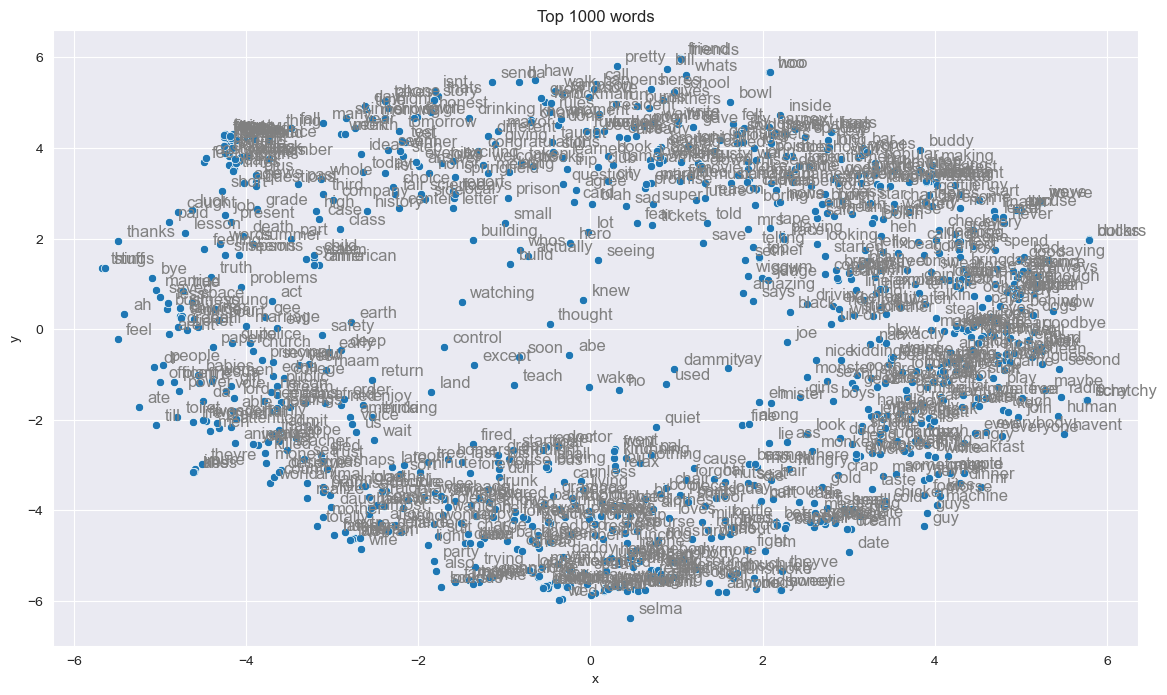

In [20]:
plt.figure(figsize=(14,8))
sns.scatterplot(data=df2,x='x',y='y')

for i in range(df2.shape[0]):
    plt.text(x=df2.x[i]+0.1,y=df2.y[i]+0.1,s=df2.word[i], 
             fontdict=dict(color='grey',size=12),
             #bbox=dict(facecolor='yellow',alpha=0.5)
            )
    
plt.title("Top 1000 words")
plt.show()

In [21]:
import chart_studio.plotly as py
import plotly.graph_objects as go
data = go.Scatter(x=df2['x'],
                  y=df2['y'],
                  text=df2['word'],
                  textposition='top right',
                  textfont=dict(color='#E58606'),
                  mode='lines+markers+text',
                  marker=dict(color='#5D69B1', size=8),
                  line=dict(color='#52BCA3', width=0, dash='dash'),
                  name='word')

fig = go.Figure(data=data)

fig.show()

Как видно из графика,некоторые группы выделяются по близости понятий: например имена главных героев  в одной группе, глаголы - в другой и т.д.
<img src='simpsons_ex.png' width=745, heigth=339>

## Ищем ближайшие слова

In [22]:
model.wv.most_similar(positive=['homer','bart'],negative=['marge'])

[('lisa', 0.6295351386070251),
 ('dad', 0.5519463419914246),
 ('maggie', 0.47202205657958984),
 ('boy', 0.4606795907020569),
 ('father', 0.4519546926021576),
 ('grampa', 0.4341423809528351),
 ('son', 0.4336407780647278),
 ('mrs', 0.43056821823120117),
 ('milhouse', 0.4153492748737335),
 ('family', 0.4119093418121338)]

In [23]:
model.wv.most_similar(positive=['bart','school'],negative=['lisa'])

[('teachers', 0.453238308429718),
 ('grades', 0.43643489480018616),
 ('teacher', 0.4299469590187073),
 ('class', 0.4171743392944336),
 ('test', 0.39642083644866943),
 ('church', 0.3775680363178253),
 ('bus', 0.37610262632369995),
 ('prep', 0.36955803632736206),
 ('krabappel', 0.36750537157058716),
 ('chalmers', 0.3662363886833191)]

In [24]:
model.wv.most_similar(positive=['marge','home'],negative=['homer'])

[('bed', 0.5712898373603821),
 ('back', 0.46999526023864746),
 ('honey', 0.45205891132354736),
 ('well', 0.3922666907310486),
 ('together', 0.3899349868297577),
 ('away', 0.37464770674705505),
 ('upstairs', 0.3718070089817047),
 ('spend', 0.3672669529914856),
 ('tired', 0.3671203553676605),
 ('parents', 0.36222511529922485)]

In [25]:
model.wv.most_similar(positive=['simpsons'],negative=['homer'])

[('incriminating', 0.41385120153427124),
 ('nineteen', 0.39277559518814087),
 ('sales', 0.3903581202030182),
 ('contains', 0.3825187385082245),
 ('youthful', 0.3742187023162842),
 ('series', 0.3739340901374817),
 ('robotic', 0.3725370168685913),
 ('creating', 0.37163373827934265),
 ('phantom', 0.3715305030345917),
 ('churches', 0.3683907091617584)]

## Обучаем классификатор

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [27]:
df2 = df[df['raw_character_text'].isin(['Bart Simpson','Lisa Simpson'])].reset_index(drop=True)
df2['raw_character_text'] = df2['raw_character_text'].map({'Bart Simpson':0,'Lisa Simpson':1})

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df2['normalized_text'], df2['raw_character_text'], test_size=0.2, random_state=42)

In [29]:
#векторизуем предложения, берём средние по словам
def vectorize(sentence,model,max_lenght=100):
    words_vecs = [model.wv[word] for word in sentence if word in model.wv]
    if len(words_vecs) == 0:
        return np.zeros(200)
    words_vecs = np.array(words_vecs)
    return np.hstack((words_vecs.mean(axis=0),words_vecs.max(axis=0)))

In [30]:
X_train = np.vstack([vectorize(x,model).ravel() for x in X_train])
X_test = np.vstack([vectorize(x,model).ravel() for x in X_test])

In [31]:
X_train.shape

(18592, 200)

In [ ]:
#ПОДБОР ГИПЕРПАРАМЕТРОВ 
param_grid = {
    'n_estimators': [20,50,100,200],
    'max_depth': [5,10,30,50],
    'class_weight': ['balanced'],
    'criterion':['gini']
}

rf = RandomForestClassifier(n_jobs = 14,random_state=42,)

forest = GridSearchCV(rf, param_grid, cv=5, scoring='precision_macro',pre_dispatch=1,verbose=10 )
forest.fit(X_train,y_train)
forest.best_estimator_

In [32]:
rf = RandomForestClassifier(n_jobs = 14,random_state=42,max_depth=50,n_estimators=300)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=50, n_estimators=300, n_jobs=14,
                       random_state=42)

In [33]:
#accuracy
(rf.predict(X_test) == y_test).sum()/X_test.shape[0]

0.6179001721170396

In [ ]:
P.S. Пробовал тренировать нейронку с RNN и CSS, показывают такой же результат, не лучше. Видимо данных не достаточно.
Хотя странно, по идее фразы должны быть совсем разными.